## Kaggle competition: Digit Recognizer

This notebook implements a hand written digit recognizer trained on MNIST dataset. It was implemented for the kaggle knowledge competition named [Digit Recognizer][1].

[1]: https://www.kaggle.com/c/digit-recognizer

### Import the necessary modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random as ran
import tensorflow as tf
import os
import pandas as pd

%matplotlib inline

### Initialize the classes and necessary paths

In [2]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [3]:
PROJECT_DIR = '/Users/sparrow/Learning/machine-learning/kaggle-competitions'
ROOT_DIR = os.path.join(PROJECT_DIR, 'digit-recognizer')
MODEL_DIR = os.path.join(ROOT_DIR, 'models')
DATASET_DIR = '/srv/downloads/moshfiqur-ml-datasets/mnist-digit'

### Load and check the data

In [4]:
df_train = pd.read_csv(os.path.join(DATASET_DIR, 'train.csv'))

In [5]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Load the data for final prediction

In [6]:
df_pred = pd.read_csv(os.path.join(DATASET_DIR, 'test.csv'))

In [7]:
df_pred.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_train.shape, df_pred.shape

((42000, 785), (28000, 784))

### Helper methods for digits overview

In [9]:
def display_digit(num):
    print(y_train[num])
    label = y_train[num].argmax(axis=0)
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

def display_mult_flat(start, stop):
    images = x_train[start].reshape([1,784])
    for i in range(start+1,stop):
        images = np.concatenate((images, x_train[i].reshape([1,784])))
    plt.imshow(images, cmap=plt.get_cmap('gray_r'))
    plt.show()

### Convert the labels to one-hot encoded

In [10]:
labels = df_train['label']

In [11]:
labels.shape

(42000,)

In [12]:
labels.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [13]:
num_classes = len(classes)
one_hot_labels = np.zeros((len(labels), num_classes))
one_hot_labels[np.arange(len(labels)), np.array(labels)] = 1

In [14]:
one_hot_labels.shape

(42000, 10)

In [15]:
# Drop the label column from df_train
if 'label' in df_train.columns:
    df_train.drop(['label'], axis=1, inplace=True)

In [16]:
df_train.shape

(42000, 784)

### Split the dataset into train and test

In [17]:
split_ratio = 0.8
num_train = int(df_train.shape[0] * split_ratio)

### Normalize the data

We must normalize the data as it contains value from 0 - 255 as the intensity of pixels. We will normalize them to be in 0 - 1 by dividing all the values by 255.

In [18]:
x_train = df_train[:num_train].values / 255
x_test = df_train[num_train:].values / 255
y_train = one_hot_labels[:num_train]
y_test = one_hot_labels[num_train:]

In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33600, 784), (33600, 10), (8400, 784), (8400, 10))

### Check some digits from training set

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


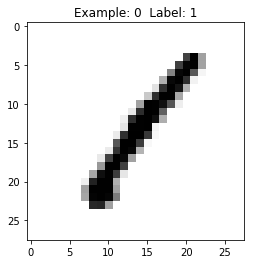

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


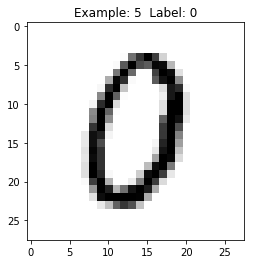

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


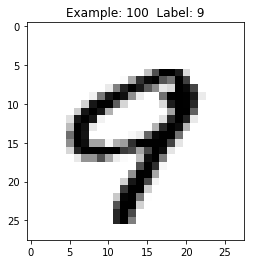

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


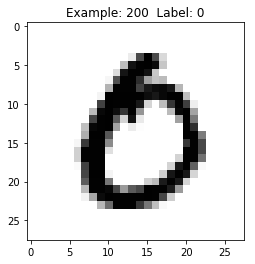

(None, None, None, None)

In [20]:
display_digit(0), display_digit(5), display_digit(100), display_digit(200)

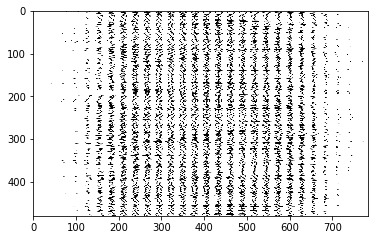

In [21]:
display_mult_flat(20, 500)

### Prepare the training

In [22]:
type(x_train), type(y_train), type(x_test), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [23]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33600, 784), (33600, 10), (8400, 784), (8400, 10))

In [24]:
x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, num_classes])
W = tf.Variable(tf.zeros([784, num_classes]))
b = tf.Variable(tf.zeros([num_classes]))
y = tf.nn.softmax(tf.matmul(x, W) + b, name='y')
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

In [25]:
LEARNING_RATE = 0.05
TRAIN_STEPS = 4000

In [26]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [27]:
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Perform the training

In [28]:
for i in range(TRAIN_STEPS+1):
    sess.run(training, feed_dict={x: x_train, y_: y_train})
    if i > 0 and i % 100 == 0:
        print('Training Step:' + str(i) + '  Accuracy =  ' + str(sess.run(accuracy, feed_dict={x: x_test, y_: y_test})) + '  Loss = ' + str(sess.run(cross_entropy, {x: x_train, y_: y_train})))

Training Step:100  Accuracy =  0.8442857  Loss = 0.78972876
Training Step:200  Accuracy =  0.86392856  Loss = 0.6040466
Training Step:300  Accuracy =  0.8742857  Loss = 0.5280118
Training Step:400  Accuracy =  0.8817857  Loss = 0.48480377
Training Step:500  Accuracy =  0.8861905  Loss = 0.4562
Training Step:600  Accuracy =  0.8897619  Loss = 0.43550724
Training Step:700  Accuracy =  0.8919048  Loss = 0.41964546
Training Step:800  Accuracy =  0.89464283  Loss = 0.4069809
Training Step:900  Accuracy =  0.8958333  Loss = 0.3965596
Training Step:1000  Accuracy =  0.89738095  Loss = 0.3877828
Training Step:1100  Accuracy =  0.8982143  Loss = 0.38025445
Training Step:1200  Accuracy =  0.89940476  Loss = 0.37369955
Training Step:1300  Accuracy =  0.9009524  Loss = 0.36792177
Training Step:1400  Accuracy =  0.9021429  Loss = 0.36277562
Training Step:1500  Accuracy =  0.90261906  Loss = 0.35815236
Training Step:1600  Accuracy =  0.90380955  Loss = 0.35396647
Training Step:1700  Accuracy =  0.90

### Save the trained model

In [29]:
# Check the parameters when saving the model
saver = tf.train.Saver(save_relative_paths=True)
saver.save(sess, os.path.join(MODEL_DIR, 'mnist_digit_model.ckpt'))

'/Users/sparrow/Learning/machine-learning/kaggle-competitions/digit-recognizer/models/mnist_digit_model.ckpt'

### Check out the trained weights 

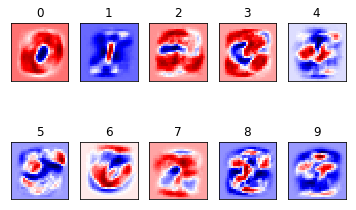

In [30]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = sess.run(W)[:,i]
    plt.title(i)
    plt.imshow(weight.reshape([28,28]), cmap=plt.get_cmap('seismic'))
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False) 
plt.show()

### Lets check some trained samples

In [31]:
def display_compare(sample_size):
    fig = plt.figure(figsize=(14, 10))
    for num in range(sample_size):
        x_train_cmp = x_train[num].reshape(1, 784)
        y_train_cmp = y_train[num]

        label = classes[y_train_cmp.argmax()]

        prediction = sess.run(y, feed_dict={x: x_train_cmp})
        prediction = prediction.argmax()
        prediction = classes[prediction]

        plt.subplot(3, 4, num+1)
        plt.title('Prediction: %s Label: %s' % (prediction, label))
        plt.imshow(x_train_cmp.reshape([28, 28]), cmap=plt.get_cmap('gray_r'))
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
    plt.show()

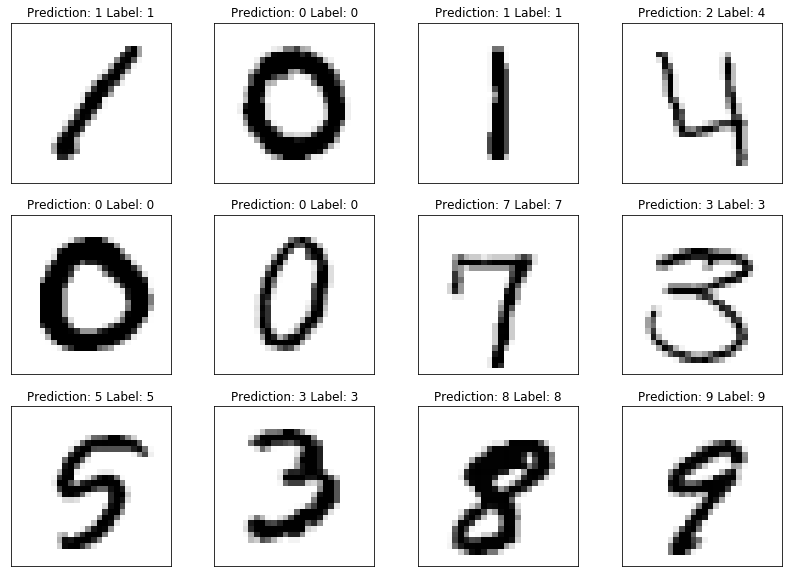

In [32]:
display_compare(12)

### Run the trained model on unseen data

For brevity's sake, lets load the trained model from disk and train using that loaded model

In [33]:
sess = tf.Session()

# Check the path when restoring the model
saver = tf.train.import_meta_graph(os.path.join(MODEL_DIR, 'mnist_digit_model.ckpt.meta'))

# Check the path when restoring the checkpoint
saver.restore(sess, tf.train.latest_checkpoint(MODEL_DIR))

graph = tf.get_default_graph()

x = graph.get_tensor_by_name('x:0')
y = graph.get_tensor_by_name('y:0')

INFO:tensorflow:Restoring parameters from /Users/sparrow/Learning/machine-learning/kaggle-competitions/digit-recognizer/models/mnist_digit_model.ckpt


In [34]:
# Converting dataframe to numpy array
x_pred = df_pred.values

### Normalize the prediction data

In [35]:
x_pred = x_pred / 255

In [36]:
x_pred.shape

(28000, 784)

In [37]:
type(x_pred)

numpy.ndarray

In [38]:
predictions = sess.run(y, feed_dict={x: x_pred})

In [39]:
predictions.shape

(28000, 10)

In [40]:
def display_prediction_compare(sample_size):
    fig = plt.figure(figsize=(14, 10))
    for i in range(sample_size):
        num = ran.randint(0, predictions.shape[0])
        x_pred_cmp = x_pred[num].reshape(1, 784)
        predictions_cmp = predictions[num]

        pred_label = classes[predictions_cmp.argmax()]

        plt.subplot(3, 4, i+1)
        plt.title('Prediction: %s' % (pred_label))
        plt.imshow(x_pred_cmp.reshape([28, 28]), cmap=plt.get_cmap('gray_r'))
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
    plt.show()

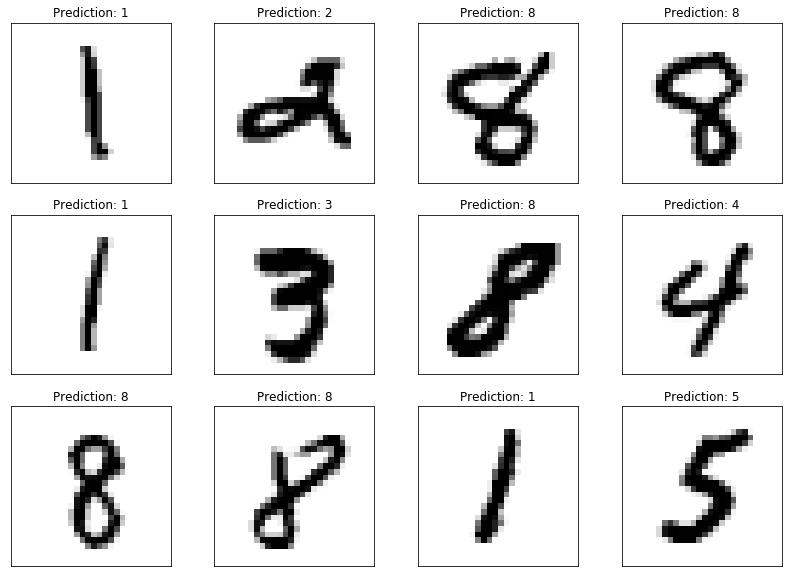

In [41]:
display_prediction_compare(12)

### Write the submission file

In [42]:
submission = []
for i in range(predictions.shape[0]):
    submission.append({'ImageId': i+1, 'Label': classes[predictions[i].argmax()]})

In [43]:
df_submission = pd.DataFrame(submission)

In [44]:
df_submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [45]:
df_submission.to_csv('submission.csv', index=False)

The final training accuracy was 0.91440475 and on kaggle I achieved 0.91157.